# Figure 010 (v001)

Clustering of cell lines by LFC.

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from typing import Sequence

import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.text import Text

In [3]:
from speclet.io import figure_img_file, tables_dir, temp_dir
from speclet.plot import PlottingMode, align_legend_title, set_speclet_theme
from speclet.plot.color_pal import (
    lineage_color_pal,
    pal_to_legend_handles,
    sublineage_color_pal,
)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
set_speclet_theme(PlottingMode.DISSERTATION)
np.random.seed(0)

In [5]:
FIGNUM, VERSION = 10, 1
FIGURE_FILE = figure_img_file(FIGNUM, VERSION, "clustering-by-lfc")
FIGURE_FILE

PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/figures/figure_010-v001/fig_010-v001_clustering-by-lfc.png')

In [6]:
nb_output_dir = tables_dir() / "005_100_lineage-data-exploration"

### Data

In [7]:
sublineage_pal = sublineage_color_pal()
lineage_pal = lineage_color_pal()

In [8]:
top_var_data_X = pd.read_csv(
    nb_output_dir / "top-variance-genes-data-wide.csv"
).set_index("depmap_id")
top_var_cg_row_labels = pd.read_csv(
    nb_output_dir / "top-variance-genes-data-row-labels.csv"
).set_index("depmap_id")
tsne_res_df = pd.read_csv(nb_output_dir / "top-variance-genes-tsne.csv")

## Figure

### Shared

In [9]:
FIGSIZE = (6.5, 7.5)
figure = plt.figure(constrained_layout=True, figsize=FIGSIZE)
subfigures = figure.subfigures(nrows=2, ncols=1, height_ratios=(2, 1))

panel_a = subfigures[0]
bottom_row_panels = subfigures[1].subfigures(ncols=2, width_ratios=(1, 1))
legend_panel = bottom_row_panels[0]
panel_b = bottom_row_panels[1]

<Figure size 650x750 with 0 Axes>

In [10]:
def short_cancers(t: str) -> str:
    replacements = {"adenocarcinoma": "adeno.", "carcinoma": "carc."}
    for k, v in replacements.items():
        t = t.replace(k, v)
    return t


def extract_subtype(t: str, shorten: bool = True) -> str:
    if "(" not in t:
        return t
    t = t.split("(")[1].replace(")", "").strip()
    if shorten:
        t = short_cancers(t)
    return t


def extract_subtypes(ts: Sequence[str], shorten: bool = True) -> list[str]:
    return [extract_subtype(t, shorten=shorten) for t in ts]


def extract_subtype_from_label(lbl: Text, shorten: bool = True) -> Text:
    lbl.set_text(extract_subtype(lbl.get_text(), shorten=shorten))
    return lbl


def extract_subtype_from_labels(
    lbls: Sequence[Text], shorten: bool = True
) -> list[Text]:
    return [extract_subtype_from_label(lbl, shorten=shorten) for lbl in lbls]

### a. Cancer genes per subtype

In [11]:
panel_a.clear()
panel_a.text(0, 0.98, r"$\textbf{a}$", fontsize=8)

top_var_cg_row_colors = top_var_cg_row_labels.assign(
    lineage=lambda d: d["lineage"].map(lineage_pal),
).drop(columns=["lineage_subtype"])

cg_figsize = (FIGSIZE[0], FIGSIZE[1] * 2 / 3)
cg = sns.clustermap(
    top_var_data_X,
    cmap="seismic",
    center=0,
    vmin=-3,
    vmax=1,
    dendrogram_ratio=(0.05, 0.1),
    figsize=cg_figsize,
    row_colors=top_var_cg_row_colors,
    cbar_pos=(0.88, 0.6, 0.01, 0.3),
)
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_xlabel("gene")
cg.ax_heatmap.set_ylabel("cell line")
cg.ax_cbar.set_title("LFC", pad=3, fontsize=7)

temp_fp = temp_dir() / "clustermap.png"
cg.savefig(temp_fp, dpi=400, pad_inches=0)
plt.close(cg.figure)

ax = panel_a.subplots()
ax.imshow(plt.imread(temp_fp))
ax.set_axis_off()

if temp_fp.exists():
    os.remove(temp_fp)

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


### b. $t$-SNE projection

In [12]:
panel_b.clear()
panel_b.text(0, 0.98, r"$\textbf{b}$", fontsize=8)
ax = panel_b.subplots()

sns.scatterplot(
    data=tsne_res_df,
    x="tsne1",
    y="tsne2",
    hue="lineage",
    palette=lineage_pal,
    s=10,
    alpha=1,
    ax=ax,
    edgecolor="k",
    linewidth=0.1,
)
ax.set_xlabel("$t$-SNE dim. 1")
ax.set_ylabel("$t$-SNE dim. 2")
ax.get_legend().remove()

### Panel with lineage legend

In [13]:
legend_panel.clear()
ax = legend_panel.subplots()
ax.axis("off")
leg = ax.legend(
    handles=pal_to_legend_handles(lineage_pal, lw=0, marker="s", markersize=4),
    loc="center",
    ncol=2,
    title="lineage",
    labelspacing=0.5,
    handlelength=0,
    handleheight=0,
    handletextpad=0.8,
    columnspacing=1,
)
align_legend_title(leg)

## Saving

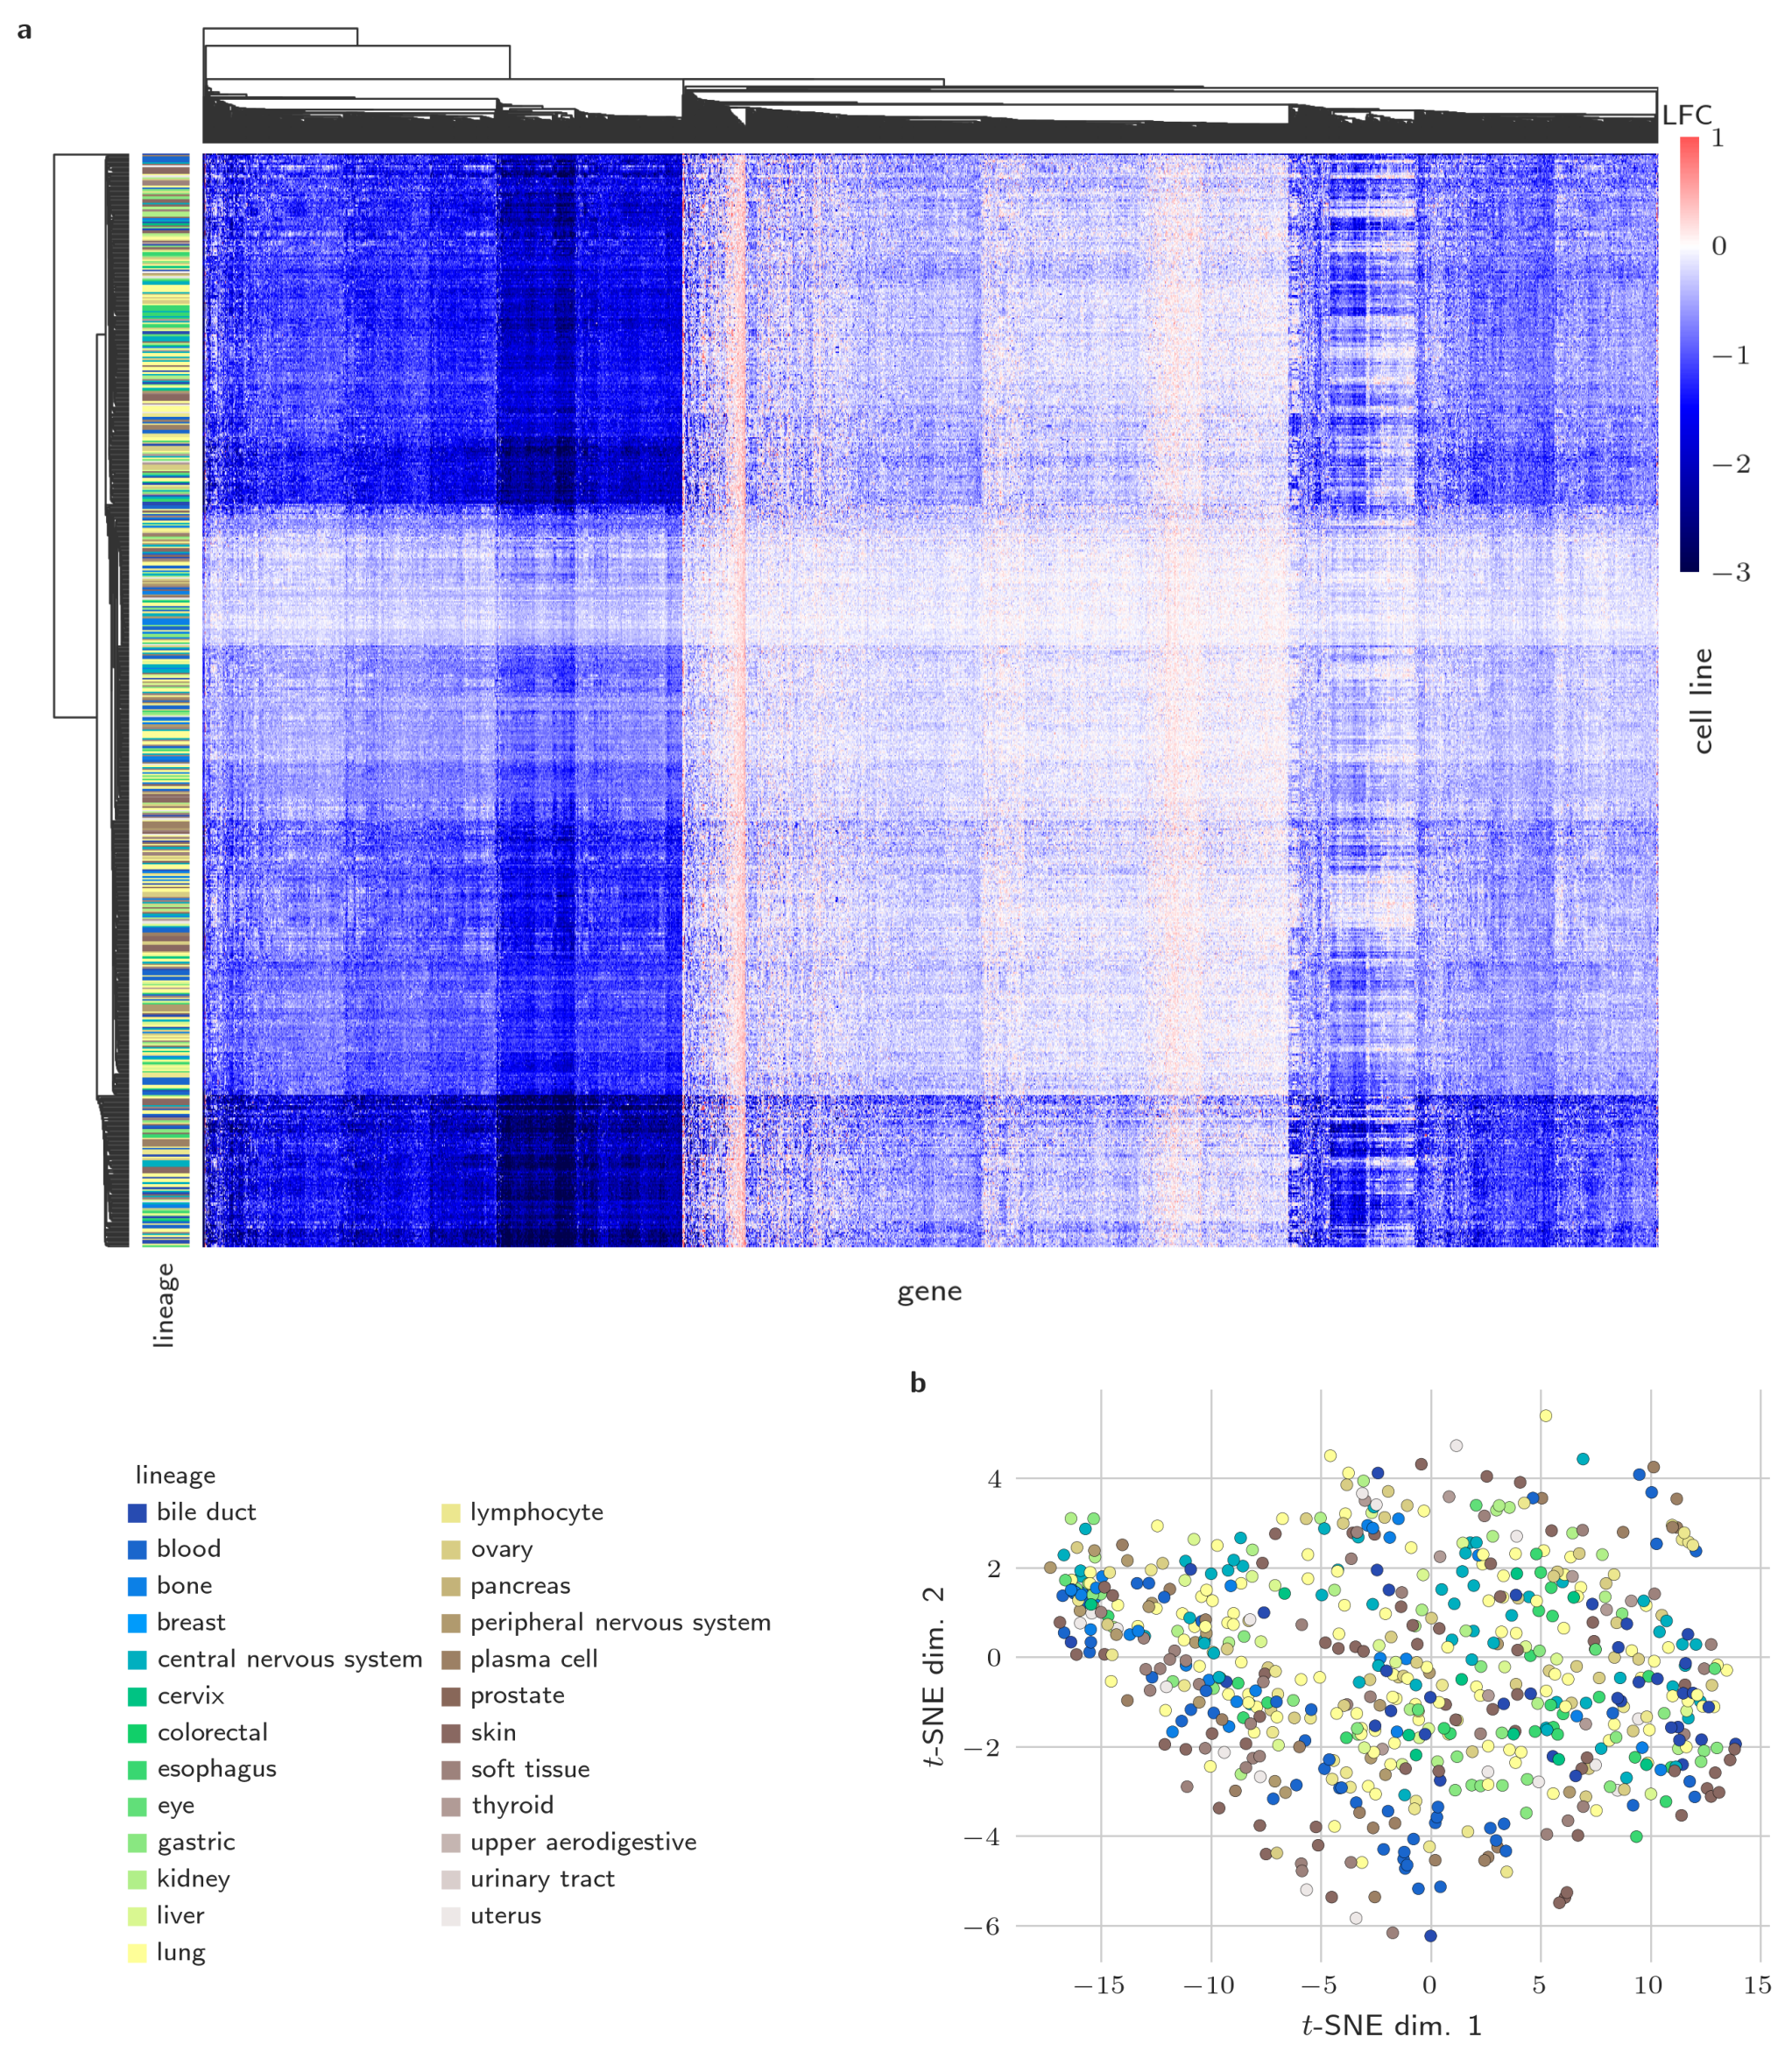

In [14]:
figure.savefig(FIGURE_FILE, dpi=400, pad_inches=0, bbox_inches="tight")

_, ax = plt.subplots(figsize=[x * 2 for x in FIGSIZE])
ax.imshow(plt.imread(FIGURE_FILE))
ax.axis("off")
plt.show()

---

## Session Info

In [15]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-23

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-236.o2.rc.hms.harvard.edu

Git branch: figures

pandas    : 1.4.4
seaborn   : 0.11.2
janitor   : 0.22.0
numpy     : 1.23.3
matplotlib: 3.5.3

